In [70]:
!curl -L -o updated-resume-dataset.zip https://www.kaggle.com/api/v1/datasets/download/jillanisofttech/updated-resume-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  382k  100  382k    0     0   649k      0 --:--:-- --:--:-- --:--:-- 2305k


Some useful regex for cleaning

In [71]:
import re
text = "http://mystuff hello there        w \n          é, à, ö, ñ 漢 (Chinese), こんにちは (Japanese), به متنی(Persian)"

# clean links
text = re.sub(r"http\S+", " ", text)
# remove all non ascii
text = re.sub(r"[^\x00-\x7f]", " ", text)
# remove extra whitespace
text = re.sub(r"\s+", " ", text)

print(text)

 hello there w , , , (Chinese), (Japanese), (Persian)


Train a knn model on a resume dataset from resume to job designation. Use what you learned in knn_sms. 

1. Read data
2. Check data
3. Clean data
4. Transform data
5. Fit model with data
6. Interpret findings with wordcloud (optional)
7. Make it predict on pdf resumes

1. Read Data

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
data = pd.read_csv('UpdatedResumeDataSet.csv', encoding='latin')
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


2. Check Data

In [74]:
data.shape

(962, 2)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [76]:
data["Category"].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

3. Clean Data

In [77]:
# string label to numerical label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Numeric Category'] = le.fit_transform(data['Category'])
data.head()

,Category,Resume,Numeric Category
0,Data Science,Skills * Programming Languages: Python (pandas...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",6
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",6


In [78]:
data.isnull().sum()

Category            0
Resume              0
Numeric Category    0
dtype: int64

In [79]:
data.duplicated().sum()

np.int64(796)

In [80]:
data.drop_duplicates(keep='first', inplace=True)

In [81]:
data.shape

(166, 3)

4. Transform Data

In [82]:
%pip install nltk
import nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [83]:
nltk.download('stopwords')
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to /home/georgu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/georgu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [84]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [85]:
def transform_text(text):
    text = text.lower()

    # clean links
    text = re.sub(r"http\S+", " ", text)
    # remove all non ascii
    text = re.sub(r"[^\x00-\x7f]", " ", text)
    # remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    text = nltk.word_tokenize(text)
    # keep only alpha numeric
    text = [word for word in text if word.isalnum()]
    stopwords = nltk.corpus.stopwords.words('english')
    # remove unimportant stop words like "the" or "to"
    text = [word for word in text if word not in stopwords]
    # only get the stem "eating" -> eat
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [86]:
transform_text('http://mystuff hello there        w \n          é, à, ö, ñ 漢 (Chinese), こんにちは (Japanese), به متنی(Persian) I am learning Python and I am learning Machine Learning')

'hello w chines japanes persian learn python learn machin learn'

In [87]:
transform_text(data['Resume'][0])

'skill program languag python panda numpi scipi matplotlib sql java machin learn regress svm na bay knn random forest decis tree boost techniqu cluster analysi word embed sentiment analysi natur languag process dimension reduct topic model lda nmf pca neural net databas visual mysql sqlserver cassandra hbase elasticsearch plotli kibana matplotlib ggplot tableau other regular express html css angular 6 logstash kafka python flask git docker comput vision open cv understand deep detail data scienc assur associ data scienc assur associ ernst young llp skill detail exprienc 24 month exprienc 24 month exprienc 24 monthscompani detail compani ernst young llp descript fraud investig disput servic assur technolog assist review tar technolog assist review assist acceler review process run analyt gener report core member team help develop autom review platform tool scratch assist e discoveri domain tool implement predict code topic model autom review result reduc labor cost time spent lawyer rev

In [88]:
data['Key Words'] = data['Resume'].apply(transform_text)
data.head()

,Category,Resume,Numeric Category,Key Words
0,Data Science,Skills * Programming Languages: Python (pandas...,6,skill program languag python panda numpi scipi...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,6,educ detail may 2013 may 2017 data scientist d...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",6,area interest deep learn control system design...
3,Data Science,Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...,6,skill r python sap hana tableau sap hana sql s...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",6,educ detail mca ymcaust faridabad haryana data...


6. Wordcloud

In [89]:
from wordcloud import WordCloud
wc = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(data['Key Words']))

In [90]:
data[data['Numeric Category'] == 6]['Key Words']

0    skill program languag python panda numpi scipi...
1    educ detail may 2013 may 2017 data scientist d...
2    area interest deep learn control system design...
3    skill r python sap hana tableau sap hana sql s...
4    educ detail mca ymcaust faridabad haryana data...
5    skill c basic iot python matlab data scienc ma...
6    skill python tableau data visual r studio mach...
7    educ detail rayat bahra institut engin biotech...
8    person skill abil quickli grasp technic aspect...
9    expertis data quantit analysi decis analyt pre...
Name: Key Words, dtype: object

Text(0.5, 1.0, 'Most common words in Data Science Resumes')

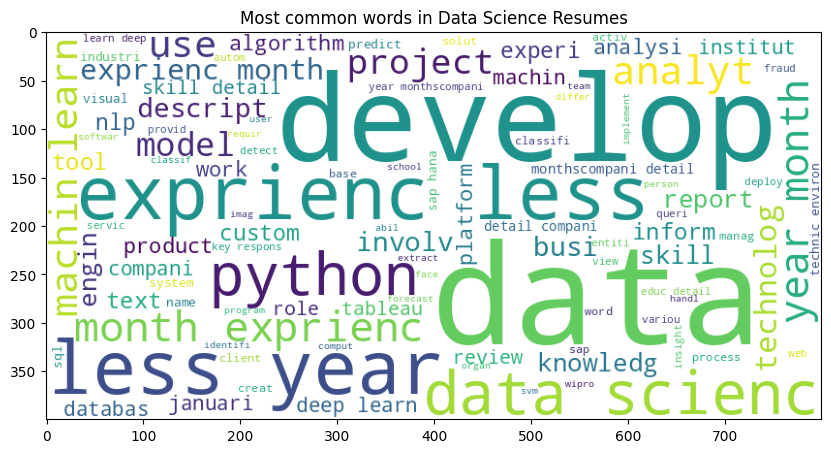

In [91]:
data_science_wc = wc.generate(' '.join(data[data['Numeric Category'] == 6]['Key Words']))
plt.figure(figsize=(10, 6))
plt.imshow(data_science_wc)
plt.title('Most common words in Data Science Resumes')

5. Fit model with data

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer() # default

In [97]:
X = data["Key Words"]
y = data["Numeric Category"]

In [100]:
vectorizer = TfidfVectorizer(stop_words="english")
vectorizer.fit(X)
features = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    features,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=2024,
)

# choose highest freq label in neighbors
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

7. Predict PDF Resumes

In [127]:
from sklearn.metrics import classification_report

print(f"train accuracy {model.score(X_train, y_train)}")
print(f"test accuracy {model.score(X_test, y_test)}")
print(f"classifying {model}")

pred = model.predict(X_test)
print(classification_report(y_test, pred, zero_division=True))

train accuracy 0.8484848484848485
test accuracy 0.8235294117647058
classifying KNeighborsClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         1
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           9       0.00      1.00      0.00         0
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       0.67      1.00      0.80         2
          16       1.00      0.50      0.67         2
          17       1.00      1.00

In [108]:
from parser import read_pdf
from parser import get_details

In [125]:
pdf_data = read_pdf("/mnt/c/Users/georg/MDST/MDST-resume-screener/bryan-resume.pdf")
details, pdf_data = get_details(pdf_data)
vectorizer.fit([pdf_data])
features = vectorizer.transform([pdf_data])
features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 156 stored elements and shape (1, 156)>